<a href="https://colab.research.google.com/github/zszazi/awesome-collection-of-google-colab-notebooks/blob/master/Pythia_VQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pythia(Facebook) -🔱 Greek God 🔱 in Action





This is a follow up of the medium article about [**Pythia**](https://https://medium.com/tensorpad/pythia-facebook-greek-god-doing-deep-learning-ff1d2a76c6d9) - Greek God Doing Deep learning

### Step 1 - Download all the required model weights , dependencies and files

In [0]:
%cd /content/

%mkdir model_data
!wget -O /content/model_data/answers_vqa.txt https://dl.fbaipublicfiles.com/pythia/data/answers_vqa.txt
!wget -O /content/model_data/vocabulary_100k.txt https://dl.fbaipublicfiles.com/pythia/data/vocabulary_100k.txt
!wget -O /content/model_data/detectron_model.pth  https://dl.fbaipublicfiles.com/pythia/detectron_model/detectron_model.pth 
!wget -O /content/model_data/pythia.pth https://dl.fbaipublicfiles.com/pythia/pretrained_models/vqa2/pythia_train_val.pth
!wget -O /content/model_data/pythia.yaml https://dl.fbaipublicfiles.com/pythia/pretrained_models/vqa2/pythia_train_val.yml
!wget -O /content/model_data/detectron_model.yaml https://dl.fbaipublicfiles.com/pythia/detectron_model/detectron_model.yaml
!wget -O /content/model_data/detectron_weights.tar.gz https://dl.fbaipublicfiles.com/pythia/data/detectron_weights.tar.gz
!tar xf /content/model_data/detectron_weights.tar.gz

### Install a few dependencies

In [0]:
!pip install ninja yacs cython matplotlib demjson
!pip install git+https://github.com/cocodataset/cocoapi.git

### Install FastText - for learning of word representations

In [0]:
%cd /content/
%rm -rf fastText
!git clone https://github.com/facebookresearch/fastText.git fastText
%cd /content/fastText
!pip install -e .

# Step 2 - Installing Pythia - Giving birth to Greek God 😁

In [0]:
%cd /content/
%rm -rf pythia
!git clone https://github.com/facebookresearch/pythia.git pythia
%cd /content/pythia
!sed -i '/torch/d' requirements.txt
!pip install -e .
import sys
sys.path.append('/content/pythia')

### Install maskrcnn-benchmark  - to extract detectron features

In [0]:

%cd /content
!git clone https://gitlab.com/meetshah1995/vqa-maskrcnn-benchmark.git
%cd /content/vqa-maskrcnn-benchmark
# Compile custom layers and build mask-rcnn backbone
!python setup.py build
!python setup.py develop
sys.path.append('/content/vqa-maskrcnn-benchmark')

# Step 3 - Pythia Demo - See Greek God in Action 🎬

### Necessary imports

In [6]:
%cd /content/
import yaml
import cv2
import torch
import requests
import numpy as np
import gc
import torch.nn.functional as F
import pandas as pd


import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from IPython.display import display, HTML, clear_output
from ipywidgets import widgets, Layout
from io import BytesIO


from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.layers import nms
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.utils.model_serialization import load_state_dict


from pythia.utils.configuration import ConfigNode
from pythia.tasks.processors import VocabProcessor, VQAAnswerProcessor
from pythia.models.pythia import Pythia
from pythia.common.registry import registry
from pythia.common.sample import Sample, SampleList



/content


### We need to pack a bunch of functions inside the class which does all the works right from feature extraction to predicting the answer

In [0]:
class PythiaDemo:
  TARGET_IMAGE_SIZE = [448, 448]
  CHANNEL_MEAN = [0.485, 0.456, 0.406]
  CHANNEL_STD = [0.229, 0.224, 0.225]
  
  def __init__(self):
    self._init_processors()
    self.pythia_model = self._build_pythia_model()
    self.detection_model = self._build_detection_model()
    self.resnet_model = self._build_resnet_model()
    
  def _init_processors(self):
    with open("/content/model_data/pythia.yaml") as f:
      config = yaml.load(f)
    
    config = ConfigNode(config)
    # Remove warning
    config.training_parameters.evalai_inference = True
    registry.register("config", config)
    
    self.config = config
    
    vqa_config = config.task_attributes.vqa.dataset_attributes.vqa2
    text_processor_config = vqa_config.processors.text_processor
    answer_processor_config = vqa_config.processors.answer_processor
    
    text_processor_config.params.vocab.vocab_file = "/content/model_data/vocabulary_100k.txt"
    answer_processor_config.params.vocab_file = "/content/model_data/answers_vqa.txt"
    # Add preprocessor as that will needed when we are getting questions from user
    self.text_processor = VocabProcessor(text_processor_config.params)
    self.answer_processor = VQAAnswerProcessor(answer_processor_config.params)

    registry.register("vqa2_text_processor", self.text_processor)
    registry.register("vqa2_answer_processor", self.answer_processor)
    registry.register("vqa2_num_final_outputs", 
                      self.answer_processor.get_vocab_size())
    
  def _build_pythia_model(self):
    state_dict = torch.load('/content/model_data/pythia.pth')
    model_config = self.config.model_attributes.pythia
    model_config.model_data_dir = "/content/"
    model = Pythia(model_config)
    model.build()
    model.init_losses_and_metrics()
    
    if list(state_dict.keys())[0].startswith('module') and \
       not hasattr(model, 'module'):
      state_dict = self._multi_gpu_state_to_single(state_dict)
          
    model.load_state_dict(state_dict)
    model.to("cuda")
    model.eval()
    
    return model
  
  def _build_resnet_model(self):
    self.data_transforms = transforms.Compose([
        transforms.Resize(self.TARGET_IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(self.CHANNEL_MEAN, self.CHANNEL_STD),
    ])
    resnet152 = models.resnet152(pretrained=True)
    resnet152.eval()
    modules = list(resnet152.children())[:-2]
    self.resnet152_model = torch.nn.Sequential(*modules)
    self.resnet152_model.to("cuda")
  
  def _multi_gpu_state_to_single(self, state_dict):
    new_sd = {}
    for k, v in state_dict.items():
        if not k.startswith('module.'):
            raise TypeError("Not a multiple GPU state of dict")
        k1 = k[7:]
        new_sd[k1] = v
    return new_sd
  
  def predict(self, url, question):
    with torch.no_grad():
      detectron_features = self.get_detectron_features(url)
      resnet_features = self.get_resnet_features(url)

      sample = Sample()

      processed_text = self.text_processor({"text": question})
      sample.text = processed_text["text"]
      sample.text_len = len(processed_text["tokens"])

      sample.image_feature_0 = detectron_features
      sample.image_info_0 = Sample({
          "max_features": torch.tensor(100, dtype=torch.long)
      })

      sample.image_feature_1 = resnet_features

      sample_list = SampleList([sample])
      sample_list = sample_list.to("cuda")

      scores = self.pythia_model(sample_list)["scores"]
      scores = torch.nn.functional.softmax(scores, dim=1)
      actual, indices = scores.topk(5, dim=1)

      top_indices = indices[0]
      top_scores = actual[0]

      probs = []
      answers = []

      for idx, score in enumerate(top_scores):
        probs.append(score.item())
        answers.append(
            self.answer_processor.idx2word(top_indices[idx].item())
        )
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return probs, answers
    
  
  def _build_detection_model(self):

      cfg.merge_from_file('/content/model_data/detectron_model.yaml')
      cfg.freeze()

      model = build_detection_model(cfg)
      checkpoint = torch.load('/content/model_data/detectron_model.pth', 
                              map_location=torch.device("cpu"))

      load_state_dict(model, checkpoint.pop("model"))

      model.to("cuda")
      model.eval()
      return model
  
  def get_actual_image(self, image_path):
      if image_path.startswith('http'):
          path = requests.get(image_path, stream=True).raw
      else:
          path = image_path
      
      return path

  def _image_transform(self, image_path):
      path = self.get_actual_image(image_path)

      img = Image.open(path)
      im = np.array(img).astype(np.float32)
      im = im[:, :, ::-1]
      im -= np.array([102.9801, 115.9465, 122.7717])
      im_shape = im.shape
      im_size_min = np.min(im_shape[0:2])
      im_size_max = np.max(im_shape[0:2])
      im_scale = float(800) / float(im_size_min)
      # Prevent the biggest axis from being more than max_size
      if np.round(im_scale * im_size_max) > 1333:
           im_scale = float(1333) / float(im_size_max)
      im = cv2.resize(
           im,
           None,
           None,
           fx=im_scale,
           fy=im_scale,
           interpolation=cv2.INTER_LINEAR
       )
      img = torch.from_numpy(im).permute(2, 0, 1)
      return img, im_scale


  def _process_feature_extraction(self, output,
                                 im_scales,
                                 feat_name='fc6',
                                 conf_thresh=0.2):
      batch_size = len(output[0]["proposals"])
      n_boxes_per_image = [len(_) for _ in output[0]["proposals"]]
      score_list = output[0]["scores"].split(n_boxes_per_image)
      score_list = [torch.nn.functional.softmax(x, -1) for x in score_list]
      feats = output[0][feat_name].split(n_boxes_per_image)
      cur_device = score_list[0].device

      feat_list = []

      for i in range(batch_size):
          dets = output[0]["proposals"][i].bbox / im_scales[i]
          scores = score_list[i]

          max_conf = torch.zeros((scores.shape[0])).to(cur_device)

          for cls_ind in range(1, scores.shape[1]):
              cls_scores = scores[:, cls_ind]
              keep = nms(dets, cls_scores, 0.5)
              max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep],
                                           cls_scores[keep],
                                           max_conf[keep])

          keep_boxes = torch.argsort(max_conf, descending=True)[:100]
          feat_list.append(feats[i][keep_boxes])
      return feat_list

  def masked_unk_softmax(self, x, dim, mask_idx):
      x1 = F.softmax(x, dim=dim)
      x1[:, mask_idx] = 0
      x1_sum = torch.sum(x1, dim=1, keepdim=True)
      y = x1 / x1_sum
      return y
   
  def get_resnet_features(self, image_path):
      path = self.get_actual_image(image_path)
      img = Image.open(path).convert("RGB")
      img_transform = self.data_transforms(img)
      
      if img_transform.shape[0] == 1:
        img_transform = img_transform.expand(3, -1, -1)
      img_transform = img_transform.unsqueeze(0).to("cuda")
      
      features = self.resnet152_model(img_transform).permute(0, 2, 3, 1)
      features = features.view(196, 2048)
      return features
    
  def get_detectron_features(self, image_path):
      im, im_scale = self._image_transform(image_path)
      img_tensor, im_scales = [im], [im_scale]
      current_img_list = to_image_list(img_tensor, size_divisible=32)
      current_img_list = current_img_list.to('cuda')
      with torch.no_grad():
          output = self.detection_model(current_img_list)
      feat_list = self._process_feature_extraction(output, im_scales, 
                                                  'fc6', 0.2)
      return feat_list[0]

### Create Class Object (Re-run below cell if you get '`CUDNN_EXECUTION_FAILED`'  error)

In [0]:
greek_god = PythiaDemo()

### Create a Widget to Interact with the God 🔱

Use Text Field to give Image Url and get answered

Text(value='https://www.cricbuzz.com/i/stats/fth/540x303/venue/images/11.jpg', description='Image URL')

Text(value='how many stadium lights are there?', description='Question-Get answer from God')

Button(description='🔱 Ask Pythia! 🔱', style=ButtonStyle())

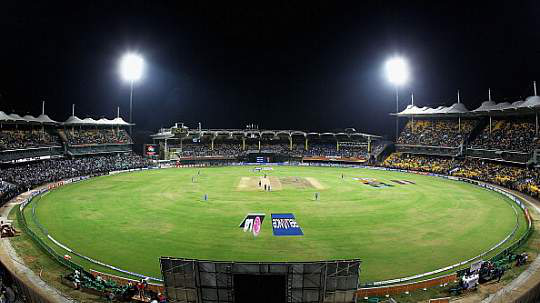

,Prediction,Confidence
0,2,72.039944
1,3,13.151835
2,4,10.497709
3,1,1.697884
4,5,0.821344


In [0]:
def init_widgets(url, question):
  image_text = widgets.Text(
    description="Image URL", layout=Layout(minwidth="70%")
  )
  question_text = widgets.Text(
      description="Question-Get answer from God", layout=Layout(minwidth="70%")
  )

  image_text.value = url
  question_text.value = question
  submit_button = widgets.Button(description="🔱 Ask Pythia! 🔱")

  display(image_text)
  display(question_text)
  display(submit_button)

  submit_button.on_click(lambda b: on_button_click(
      b, image_text, question_text
  ))
  
  return image_text, question_text
  
def on_button_click(b, image_text, question_text):
  clear_output()
  image_path = greek_god.get_actual_image(image_text.value)
  image = Image.open(image_path)
  
  scores, predictions = greek_god.predict(image_text.value, question_text.value)
  scores = [score * 100 for score in scores]
  df = pd.DataFrame({
      "Prediction": predictions,
      "Confidence": scores
  })
  
  init_widgets(image_text.value, question_text.value)
  display(image)
  
  display(HTML(df.to_html()))
 

image_text, question_text = init_widgets(
    "https://www.cricbuzz.com/i/stats/fth/540x303/venue/images/11.jpg", 
    "How many stadium lights are there?"
)


*Most of the code has been adopted from Pythia's Github repo*

---

